# Playing with sample kHz QPO dataset

In [82]:
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

In [116]:
lc_fits = Table.read('./toy_kHz_lightcurve.fits')
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
lc_fits

<Table length=32768>
name  dtype   shape 
---- ------- -------
 REF float64   (20,)
  CI float64 (5, 20)
None
OrderedDict([('N_BINS', 32768), ('DT', 0.00048828125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Dropbox/Research/kHz_QPO_phase_res/toy_chbinfile.txt'), ('N_SEG', 20), ('NSECONDS', 16)])


REF [20],"CI [5,20]"
float64,float64
2048.0 .. 0.0,0.0 .. 0.0
2048.0 .. 4096.0,0.0 .. 0.0
0.0 .. 0.0,0.0 .. 0.0
6144.0 .. 0.0,0.0 .. 0.0
2048.0 .. 4096.0,0.0 .. 0.0
4096.0 .. 0.0,0.0 .. 0.0
6144.0 .. 4096.0,0.0 .. 0.0
2048.0 .. 2048.0,0.0 .. 0.0
0.0 .. 2048.0,0.0 .. 0.0


In [118]:
# multiply dt to get counts
ref = lc_fits['REF'] * dt
ci = lc_fits['CI'] * dt
print(ref.shape, ci.shape)

(32768, 20) (32768, 5, 20)


## What I learned about the dataset
Given dataset has:-
-  2 sets of lightcurves (REF and CI)
-  5 channels of interest
-  32768 bins of photon energy
-  20 sequential segments
-  'count rate' as unit

In [111]:
print(ref)
print(ref[0])

 REF [20] 
----------
1.0 .. 0.0
1.0 .. 2.0
0.0 .. 0.0
3.0 .. 0.0
1.0 .. 2.0
2.0 .. 0.0
3.0 .. 2.0
1.0 .. 1.0
0.0 .. 1.0
3.0 .. 1.0
       ...
3.0 .. 2.0
1.0 .. 1.0
0.0 .. 1.0
0.0 .. 0.0
2.0 .. 0.0
2.0 .. 1.0
1.0 .. 1.0
0.0 .. 1.0
0.0 .. 1.0
0.0 .. 2.0
1.0 .. 1.0
Length = 32768 rows
[1. 0. 1. 1. 0. 3. 0. 0. 1. 1. 1. 1. 2. 1. 0. 0. 3. 2. 2. 0.]


32768


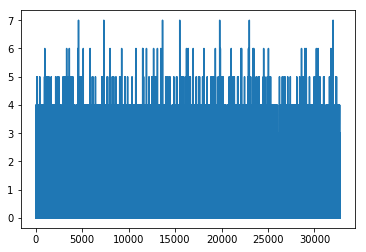

In [199]:
seg_1 = 1
seg_2 = 2
counts = np.array(ref[:,seg_1:seg_2]) # Flatten first `x` rows (x = 10)
times = np.arange(len(counts))
print(len(counts))
lc = Lightcurve(times, counts)
lc.plot()

## Powerspectrum and AveragedPowerspectrum

A Powerspectrum object has the following properties :
    -  freq : Numpy array of mid-bin frequencies that the Fourier transform samples.
    -  power : Numpy array of the power spectrum.
    -  df : The frequency resolution.
    -  m : The number of power spectra averaged together. For a Powerspectrum of a single segment, m=1.
    -  n : The number of data points (time bins) in one segment of the light curve.
    -  nphots1 : The total number of photons in the light curve.


In [200]:
ps = Powerspectrum(lc)

print(len(ps.freq))
print(ps.freq)
print(ps.power)
print(ps.df)
print(ps.m)
print(ps.n)
print(ps.nphots1)

16383
[3.05175781e-05 6.10351562e-05 9.15527344e-05 ... 4.99908447e-01
 4.99938965e-01 4.99969482e-01]
[[4.32571507e-04]
 [1.92254003e-04]
 [4.80635008e-05]
 ...
 [0.00000000e+00]
 [1.92254003e-04]
 [0.00000000e+00]]
3.0517578125e-05
1
32768
36926.0


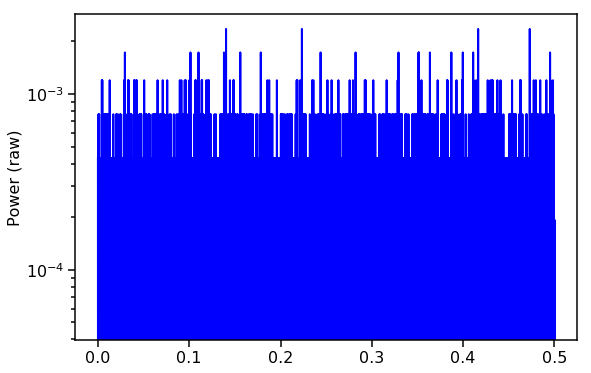

In [201]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6), sharex=True)
ax1.plot(ps.freq, ps.power, lw=2, color='blue')
ax1.set_ylabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

In [202]:
avg_ps = AveragedPowerspectrum(lc, 16)

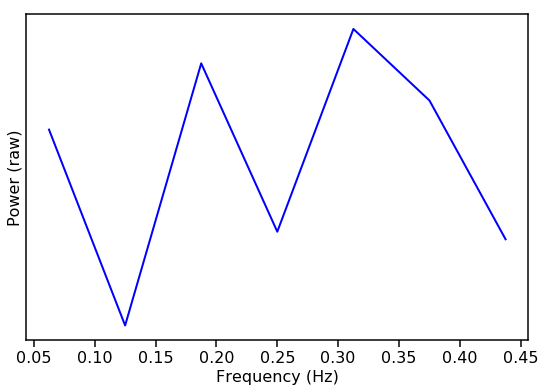

In [196]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(avg_ps.freq, avg_ps.power, lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

In [197]:
meta['NSECONDS']/dt

32768.0